### Runs an extended Kalman filter using IHME SEIIR predictions along with measurement data of confirmed Covid-19 case counts (from New York Times data) and Facebook symptom data (loss of smell/taste, from Covid-19 Symptom Challenge) to generate updated 7-day predictions of case counts for counties in New York State.

Developed by the University of Washington team of Les Atlas, Abraham Flaxman and Michael Rhoads.

S - Susceptible
E - Exposed
I1 - Presymptomatic
I2 - Symptomatic
R - Recovered

In [16]:
#%load_ext autoreload
#%autoreload

In [17]:
#%reset

In [18]:
import math
import datetime

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import data_sets
import seiir_compartmental

In [19]:
# functions to support the Kalman filtering
def get_predicts_prior(day, seiir):
    x_hat = np.array([[seiir['S'].loc[day]],
                      [seiir['E'].loc[day]],
                      [seiir['I1'].loc[day]],
                      [seiir['I2'].loc[day]],
                      [seiir['R'].loc[day]]])

    beta_k = seiir['beta'].loc[day]

    return x_hat, beta_k


def step_seiir(x_hat, constants, beta_k, days=7):
    s_dict = {'S': x_hat[0, 0],
              'E': x_hat[1, 0],
              'I1': x_hat[2, 0],
              'I2': x_hat[3, 0],
              'R': x_hat[4, 0]}

    s = pd.Series(s_dict)

    for i in range(days):
        infectious = s.loc['I1'] + s.loc['I2']
        s = seiir_compartmental.compartmental_covid_step(s, s.sum(),
                                                         infectious,
                                                         constants['alpha'],
                                                         beta_k,
                                                         constants['gamma1'],
                                                         constants['gamma2'],
                                                         constants['sigma'],
                                                         constants['theta'])
    x_hat_future_prior = np.array([[s.loc['S']],
                                   [s.loc['E']],
                                   [s.loc['I1']],
                                   [s.loc['I2']],
                                   [s.loc['R']]])

    return x_hat_future_prior


def predict_step(x_hat_k1_prior, P, Q, beta_k, constants):
    S = x_hat_k1_prior[0, 0]
    E = x_hat_k1_prior[1, 0]
    I1 = x_hat_k1_prior[2, 0]
    I2 = x_hat_k1_prior[3, 0]
    R = x_hat_k1_prior[4, 0]
    N = S + E + I1 + I2 + R
    alpha = constants['alpha']
    sigma = constants['sigma']
    gamma1 = constants['gamma1']
    gamma2 = constants['gamma2']

    part_f_S = np.array([[-beta_k * math.pow(I1 + I2, alpha) / N],
                         [beta_k * math.pow(I1 + I2, alpha) / N],
                         [0],
                         [0],
                         [0]])

    part_f_E = np.array([[0],
                         [-sigma],
                         [sigma],
                         [0],
                         [0]])

    part_f_I1 = np.array([[-alpha * beta_k * S * math.pow(I1+I2, alpha-1) / N],
                          [alpha * beta_k * S * math.pow(I1+I2, alpha-1) / N],
                          [-gamma1],
                          [gamma1],
                          [0]])

    part_f_I2 = np.array([[-alpha * beta_k * S * math.pow(I1+I2, alpha-1) / N],
                          [alpha * beta_k * S * math.pow(I1+I2, alpha-1) / N],
                          [0],
                          [-gamma2],
                          [gamma2]])

    part_f_R = np.array([[0],
                         [0],
                         [0],
                         [0],
                         [0]])

    # 5x5
    f_jacob = np.concatenate([part_f_S, part_f_E, part_f_I1, part_f_I2,
                              part_f_R], axis=1)

    # 5x5
    # P_k1_prior = f_jacob * P * f_jacob^T + Q
    P_k1_prior = np.matmul(np.matmul(f_jacob, P), np.transpose(f_jacob)) + Q
    return P_k1_prior


def update_step(x_hat, x_hat_k1, P_k1, Rn, rho1, rho2, z_k):
    # 5x5
    ep = 10**-8
    
    H = np.array([[ep, 0, 0, 0, 0],
                  [0, ep, 0, 0, 0],
                  [0, 0, ep, rho1, 0],
                  [0, 0, 0, rho2, 0],
                  [0, 0, 0, 0, ep]])
    
    
    # Si = H * P_k1 * H^T + Rn
    Si = np.matmul(np.matmul(H, P_k1), np.transpose(H)) + Rn

    # K_new = P_k1 * H^T * Si^(-1)
    K_new = np.matmul(np.matmul(P_k1, np.transpose(H)), np.linalg.inv(Si))
    y_new = np.matmul(H, x_hat)

    # 5x1
    diff = z_k - y_new

    x_hat_k1_post = x_hat_k1 + np.matmul(K_new, diff)

    P_k1_post = P_k1 - np.matmul(np.matmul(K_new, Si), np.transpose(K_new))


    return x_hat_k1_post, P_k1_post, diff, K_new[3, 3]


def get_data_sets(state, fips=None):
    # the post hoc seiir model predictions provided by Prof Flaxman without
    # any kalman filtering:
    if state == 'New York':
        filename = 'new_york'
    elif state == 'Florida':
        filename = 'florida'
            
    seiir = pd.read_csv(r'data/seiir_projections/' + filename + '_proj.csv', header=0,
                        index_col='date', parse_dates=True)
    

    fb_data = data_sets.create_symptom_df()
    fb_data_val = data_sets.create_symptom_df(valid=True)

    if fips is None:
        case_data = data_sets.create_case_df_state()
        case_data_geo = case_data.loc[state]['case_rate'].copy()
        fb_data_geo = fb_data.loc[state].groupby('date').sum().copy()
        fb_data_val_geo = fb_data_val.loc[state].groupby('date').sum().copy()

    else:
        case_data = data_sets.create_case_df_county()
        case_data_geo = case_data.loc[fips]['case_rate'].copy()
        
        if fips == 'New York City':
            nyc_fips = ['36005', '36061', '36047', '36085']
            fb_data_geo = fb_data.loc[(slice(None), '36081'), :].copy()
            fb_data_geo = fb_data_geo.mean(level='date')
            fb_data_val_geo = fb_data_val.loc[(slice(None), '36081'), :].copy()
            fb_data_val_geo = fb_data_val.mean(level='date')
            for borough in nyc_fips:
                fb_data_geo += fb_data.loc[(slice(None), borough), :].copy().mean(level='date')
                fb_data_val_geo += fb_data_val.loc[(slice(None), borough), :].copy().mean(level='date')
        else:
            fb_data_geo = fb_data.loc[(slice(None), fips), :].copy()
            fb_data_val_geo = fb_data_val.loc[(slice(None), fips), :].copy()
            # collapse down to a single index column (date)
            fb_data_geo = fb_data_geo.mean(level='date')
            fb_data_val_geo = fb_data_val_geo.mean(level='date')


    return seiir, fb_data_geo, fb_data_val_geo, case_data_geo


def calc_fb_ma7(fb_data):
    """
    Returns a Pandas series
    """
    # the fb_data is a DataFrame while the case_data is a Series
    fb_ma7 = fb_data.rolling(window=7).mean()
    fb_ma7 = fb_ma7.iloc[6:, :]
    prop_ma7 = fb_ma7['num_stl'].div(fb_ma7['n'])

    return prop_ma7, fb_ma7['n'].copy(), fb_ma7['num_stl'].copy()


def calc_mse(prediction, actual):
    """
    Inputs should be two Pandas Series of same length.
    Outputs a float.
    """
    err = prediction - actual
    sum_sq_err = (err**2).sum()
    mse = sum_sq_err / err.count()
    return mse


def get_hh_data():
    # bring in new data
    full_data = pd.read_csv(r'data/from_challenge/overall-county.csv', header=0, dtype={'fips': 'str', 'pct_hh_cli': 'float64'},
                            parse_dates=[0])
    time_start = full_data['date'].min()
    time_end = full_data['date'].max()
    full_data.set_index(['fips', 'date'], inplace=True)
    full_data.sort_index(inplace=True)

    # derive count of survey respondents with household members having covid symptoms
    full_data['num_hh_cli'] = full_data['n'].mul(full_data['pct_hh_cli']/100.).round()
    full_data['num_hh_cli'] = full_data['num_hh_cli'].astype('int64')

    # group by county and date
    data_of_interest = full_data[['n', 'num_hh_cli']].copy().groupby(level=(0, 1)).sum()
    idx = pd.IndexSlice

    # create full date range
    date_rng = pd.date_range(time_start, time_end)
    iterables = [data_of_interest.index.levels[0], date_rng]
    new_index = pd.MultiIndex.from_product(iterables, names=['fips', 'date'])

    data_of_interest = data_of_interest.reindex(index=new_index)
    # this will have NaN values in the new index entries for which there was no
    # previous data -- fill them upon extracting a particular county
    
    return data_of_interest


In [20]:
def run_county(the_state, county_name, measure='smell', K0=datetime.date(2020, 4, 18), delay=6):

    # set constants
    #K0 = datetime.date(2020, 4, 12)

    if county_name == 'New York City':
        the_county = county_name
    else:
        the_county = data_sets.get_fips(the_state, county_name)

    constants = {
        'alpha': 0.948786,
        'gamma1': 0.500000,
        'gamma2': 0.662215,
        'sigma': 0.266635,
        'theta': 6.000000
        }

    # set initial values for Kalman filter parameters
    P_mult = 1
    Q_mult = 1

    # Rn is the R noise covariance matrix; it remains constant thru the stepping of the
    # Kalman filter
    Rn_mult = 5*10**-8

    Rn_22 = 10000
    Rn_32 = 1000

    Rn_23 = 1000
    Rn_33 = 100

    Rn = Rn_mult * np.array([[0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 0],
                             [0, 0, Rn_22, Rn_23, 0],
                             [0, 0, Rn_32, Rn_33, 0],
                             [0, 0, 0, 0, 0]])

    Q = Q_mult * np.eye(5)
    P = P_mult * np.eye(5)
    
    if the_county == 'New York City':
        county_pop = 0
        for each in ['36081', '36005', '36061', '36047', '36085']:
            this_count, state_pop = data_sets.get_pops(each)
            county_pop += this_count
    else:
        county_pop, state_pop = data_sets.get_pops(the_county)

    b = county_pop / state_pop

    # generate data
    seiir, fb_data, fb_data_val, case_data = get_data_sets(
        data_sets.STATES[the_state], fips=the_county)

    if measure == 'hh':
        print('hh')
        data_of_interest = get_hh_data()
        idx = pd.IndexSlice
        hh_cli = data_of_interest.loc[idx[the_county, :], :].loc[the_county].copy()
        hh_cli.fillna(method='pad', inplace=True)

        # calculate moving averages on the fb and case data
        hh_cli_ma7 = hh_cli.rolling(window=7).mean()
        hh_cli_ma7 = hh_cli_ma7.iloc[6:, :]
        num_survey_ma7 = hh_cli_ma7['num_hh_cli']
        prop_cli_ma7 = num_survey_ma7.div(hh_cli_ma7['n'])
        
    elif measure == 'smell':
        prop_ma7, n_ma7, num_survey_ma7 = calc_fb_ma7(fb_data)


    case_ma7 = case_data.rolling(window=7).mean()
    case_ma7_all = case_ma7.iloc[6:]
    

    # get starting compartment values for the state level
    x_hat_state_k0, beta_k0 = get_predicts_prior(K0, seiir)

    # convert to the county level
    x_hat_k0 = b * x_hat_state_k0

    I2_county = x_hat_k0[3, 0]


    rho1 = 0.0001
    rho2 = case_ma7_all.loc['2020-04-12'] / I2_county


    # create empty dictionaries to hold the estimated values
    case_est = {}
    seiir_pred = {}

    diff_rat = {}

    K_val_dict = {}


    # Original data run ----------------
    start = K0
    d = start
    #while d <= datetime.date(2020, 9, 30):
    while d <= datetime.date(2020, 10, 23):    

    # each cycle of the while loop executes a step

        # get state level compartments
        x_hat_state_k, beta_k = get_predicts_prior(d, seiir)

        # step the state level compartments 7 days forward
        x_hat_state_k1 = step_seiir(x_hat_state_k, constants, beta_k)

        # convert the state level compartments to county level values
        x_hat_k = b * x_hat_state_k
        x_hat_k1 = b * x_hat_state_k1

        indexDate = d + datetime.timedelta(days=7)
        # store seiir prediction before it's modified by Kalman filter
        seiir_pred[indexDate] = x_hat_k1[3, 0]

        # get measurements for current day
        if measure == 'smell':
            z_k = np.array([[0],
                            [0],
                            [prop_ma7.loc[d - datetime.timedelta(days=delay)]],
                            [case_ma7_all.loc[d]],
                            [0]])    

        elif measure == 'hh':
            z_k = np.array([[0],
                            [0],
                            [prop_cli_ma7.loc[d - datetime.timedelta(days=delay)]],
                            [case_ma7_all.loc[d]],
                            [0]])
        

        # predict step using the stepped fwd SEIIR compartment values 
        P = predict_step(x_hat_k1, P, Q, beta_k, constants)
        print('step -----------')
        print('P:')
        print(P)

        # update step
        x_hat_post, P_post, the_diff, K_val = update_step(x_hat_k, x_hat_k1, P, Rn,
                                         rho1, rho2, z_k)
        print('P_post:')
        print(P_post)


        # store estimated values for proportion and case rate
        K_val_dict[indexDate] = K_val
        case_est[indexDate] = rho2 * x_hat_post[3, 0]


        diff_rat[indexDate] = the_diff[2, 0] / the_diff[3, 0]

        # update the P and d
        P = P_post
        d += datetime.timedelta(days=1)

    # create pandas series of the estimated case rate
    predicted_case = pd.Series(case_est)
    predicted_seiir_prior = pd.Series(seiir_pred)
    K_val_series = pd.Series(K_val_dict)
    
    return predicted_case, predicted_seiir_prior, case_ma7_all, num_survey_ma7, K_val_series

In [21]:
predicted_case, predicted_seiir_prior, case_ma7_all, num_survey_ma7, K_vals = run_county('NY', 'Westchester', measure='hh', K0=datetime.date(2020, 4, 18), delay=6)

hh
step -----------
P:
[[ 1.11255157 -0.11255157  0.11860974  0.03848056 -0.1570903 ]
 [-0.11255157  1.18364579 -0.18970397 -0.03848056  0.1570903 ]
 [ 0.11860974 -0.18970397  1.32109422 -0.25        0.        ]
 [ 0.03848056 -0.03848056 -0.25        1.68852871 -0.43852871]
 [-0.1570903   0.1570903   0.         -0.43852871  1.43852871]]
P_post:
[[-2.22044605e-16  2.77555756e-16  7.07767178e-16 -5.30825384e-15
   3.71924713e-15]
 [ 2.63677968e-16  0.00000000e+00 -8.32667268e-17  4.78783679e-16
   8.32667268e-17]
 [ 7.07767178e-16 -5.55111512e-17  1.24102159e+00  7.48096368e-09
   1.57805189e-16]
 [-5.32213162e-15  4.78783679e-16  7.48096374e-09 -6.66133815e-16
   1.33226763e-15]
 [ 3.71924713e-15  8.32667268e-17  1.63574194e-16  1.27675648e-15
  -1.11022302e-15]]
step -----------
P:
[[ 1.06946180e+00 -6.94617989e-02  1.46802242e-01 -1.46802240e-01
  -1.17203305e-09]
 [-6.94617989e-02  1.06946180e+00 -1.46802242e-01  1.46802240e-01
   1.17203297e-09]
 [ 1.46802242e-01 -1.46802242e-01  1.

P_post:
[[ 0.00000000e+00  2.28983499e-16 -1.66533454e-16  6.66133815e-16
   2.89513214e-24]
 [ 2.28983499e-16  2.22044605e-16  0.00000000e+00  2.77555756e-17
   2.06795153e-25]
 [-1.94289029e-16  0.00000000e+00  1.21291887e+00  7.31155914e-09
  -4.13590306e-25]
 [ 6.66133815e-16  2.77555756e-17  7.31155914e-09  0.00000000e+00
   0.00000000e+00]
 [ 2.68833699e-24  6.20385459e-25 -4.13590306e-25  0.00000000e+00
   1.11022302e-16]]
step -----------
P:
[[ 1.05994269e+00 -5.99426878e-02  1.34819896e-01 -1.34819895e-01
  -1.07636914e-09]
 [-5.99426878e-02  1.05994269e+00 -1.34819896e-01  1.34819895e-01
   1.07636914e-09]
 [ 1.34819896e-01 -1.34819896e-01  1.30322972e+00 -3.03229716e-01
  -2.42091206e-09]
 [-1.34819895e-01  1.34819895e-01 -3.03229716e-01  1.30322971e+00
   2.42091207e-09]
 [-1.07636914e-09  1.07636914e-09 -2.42091206e-09  2.42091207e-09
   1.00000000e+00]]
P_post:
[[-2.22044605e-16  1.38777878e-17  8.32667268e-17 -5.82867088e-16
  -1.24077092e-24]
 [ 2.08166817e-17  4.440892

P_post:
[[ 2.22044605e-16  1.80411242e-16 -4.71844785e-16  2.08166817e-15
  -2.06795153e-25]
 [ 1.80411242e-16  6.66133815e-16 -2.77555756e-17 -2.77555756e-17
   0.00000000e+00]
 [-4.71844785e-16 -2.77555756e-17  1.21053873e+00  7.29721167e-09
   0.00000000e+00]
 [ 2.08166817e-15 -5.55111512e-17  7.29721167e-09 -2.22044605e-16
  -1.24077092e-24]
 [-2.06795153e-25  0.00000000e+00  1.27801344e-17 -1.24077092e-24
   1.11022302e-16]]
step -----------
P:
[[ 1.06964983e+00 -6.96498295e-02  1.45184207e-01 -1.45184206e-01
  -1.15911527e-09]
 [-6.96498295e-02  1.06964983e+00 -1.45184207e-01  1.45184206e-01
   1.15911527e-09]
 [ 1.45184207e-01 -1.45184207e-01  1.30263468e+00 -3.02634680e-01
  -2.41616152e-09]
 [-1.45184206e-01  1.45184206e-01 -3.02634680e-01  1.30263468e+00
   2.41616161e-09]
 [-1.15911527e-09  1.15911528e-09 -2.41616152e-09  2.41616161e-09
   1.00000000e+00]]
P_post:
[[ 0.00000000e+00 -4.16333634e-17  8.32667268e-17 -2.77555756e-16
   2.27474668e-24]
 [-4.16333634e-17 -4.440892

step -----------
P:
[[ 1.08418662e+00 -8.41866211e-02  1.59259372e-01 -1.59259371e-01
  -1.27148791e-09]
 [-8.41866211e-02  1.08418662e+00 -1.59259372e-01  1.59259371e-01
   1.27148792e-09]
 [ 1.59259372e-01 -1.59259372e-01  1.30127765e+00 -3.01277651e-01
  -2.40532726e-09]
 [-1.59259371e-01  1.59259371e-01 -3.01277651e-01  1.30127765e+00
   2.40532735e-09]
 [-1.27148792e-09  1.27148793e-09 -2.40532728e-09  2.40532737e-09
   1.00000000e+00]]
P_post:
[[-2.22044605e-16 -1.24900090e-16  1.94289029e-16 -9.43689571e-16
  -6.20385459e-25]
 [-1.24900090e-16  0.00000000e+00 -5.55111512e-17 -2.77555756e-17
   0.00000000e+00]
 [ 1.38777878e-16  0.00000000e+00  1.20499947e+00  7.26382027e-09
   0.00000000e+00]
 [-9.15933995e-16 -5.55111512e-17  7.26382027e-09  0.00000000e+00
  -8.27180613e-25]
 [-8.27180613e-25  0.00000000e+00 -1.25091484e-17 -8.27180613e-25
   0.00000000e+00]]
step -----------
P:
[[ 1.08441832e+00 -8.44183213e-02  1.59471026e-01 -1.59471024e-01
  -1.27317772e-09]
 [-8.44183213e-

step -----------
P:
[[ 1.07719775e+00 -7.71977541e-02  1.52614938e-01 -1.52614937e-01
  -1.21844041e-09]
 [-7.71977541e-02  1.07719775e+00 -1.52614938e-01  1.52614937e-01
   1.21844045e-09]
 [ 1.52614938e-01 -1.52614938e-01  1.30170980e+00 -3.01709801e-01
  -2.40877748e-09]
 [-1.52614937e-01  1.52614937e-01 -3.01709801e-01  1.30170980e+00
   2.40877745e-09]
 [-1.21844041e-09  1.21844045e-09 -2.40877748e-09  2.40877745e-09
   1.00000000e+00]]
P_post:
[[ 2.22044605e-16 -1.52655666e-16 -5.55111512e-17  3.05311332e-16
  -1.03397577e-24]
 [-1.52655666e-16  2.22044605e-16 -2.77555756e-17  5.55111512e-17
  -2.06795153e-25]
 [ 0.00000000e+00 -5.55111512e-17  1.20720328e+00  7.27710514e-09
   0.00000000e+00]
 [ 3.05311332e-16  5.55111512e-17  7.27710514e-09  2.22044605e-16
  -2.06795153e-24]
 [-1.03397577e-24  0.00000000e+00  0.00000000e+00 -2.06795153e-24
   1.11022302e-16]]
step -----------
P:
[[ 1.07622826e+00 -7.62282619e-02  1.51676471e-01 -1.51676470e-01
  -1.21094796e-09]
 [-7.62282619e-

step -----------
P:
[[ 1.07574637e+00 -7.57463727e-02  1.51251330e-01 -1.51251329e-01
  -1.20755373e-09]
 [-7.57463727e-02  1.07574637e+00 -1.51251330e-01  1.51251329e-01
   1.20755374e-09]
 [ 1.51251330e-01 -1.51251330e-01  1.30202060e+00 -3.02020598e-01
  -2.41125876e-09]
 [-1.51251329e-01  1.51251329e-01 -3.02020598e-01  1.30202060e+00
   2.41125865e-09]
 [-1.20755372e-09  1.20755372e-09 -2.41125873e-09  2.41125864e-09
   1.00000000e+00]]
P_post:
[[ 2.22044605e-16 -3.19189120e-16  3.88578059e-16 -1.52655666e-15
   2.06795153e-24]
 [-3.19189120e-16  0.00000000e+00 -2.77555756e-17  0.00000000e+00
   0.00000000e+00]
 [ 4.16333634e-16 -5.55111512e-17  1.20778660e+00  7.28062122e-09
  -4.13590306e-25]
 [-1.55431223e-15  0.00000000e+00  7.28062127e-09  0.00000000e+00
   4.13590306e-25]
 [ 2.06795153e-24  2.06795153e-25  1.70361532e-17  4.13590306e-25
   1.11022302e-16]]
step -----------
P:
[[ 1.07689972e+00 -7.68997171e-02  1.52379828e-01 -1.52379827e-01
  -1.21656331e-09]
 [-7.68997171e-

step -----------
P:
[[ 1.09148025e+00 -9.14802534e-02  1.65881797e-01 -1.65881795e-01
  -1.32435978e-09]
 [-9.14802534e-02  1.09148025e+00 -1.65881797e-01  1.65881795e-01
   1.32435978e-09]
 [ 1.65881797e-01 -1.65881797e-01  1.30079465e+00 -3.00794644e-01
  -2.40147106e-09]
 [-1.65881795e-01  1.65881795e-01 -3.00794644e-01  1.30079464e+00
   2.40147106e-09]
 [-1.32435978e-09  1.32435978e-09 -2.40147106e-09  2.40147106e-09
   1.00000000e+00]]
P_post:
[[ 6.66133815e-16 -5.55111512e-17 -2.77555756e-17  4.44089210e-16
  -8.27180613e-25]
 [-6.93889390e-17  0.00000000e+00  0.00000000e+00 -5.55111512e-17
   4.13590306e-25]
 [ 0.00000000e+00  0.00000000e+00  1.20272526e+00  7.25011140e-09
  -8.27180613e-25]
 [ 4.44089210e-16 -2.77555756e-17  7.25011134e-09 -2.22044605e-16
   1.24077092e-24]
 [-8.27180613e-25  4.13590306e-25 -4.35185841e-18  1.65436123e-24
   1.11022302e-16]]
step -----------
P:
[[ 1.09252423e+00 -9.25242343e-02  1.66794210e-01 -1.66794208e-01
  -1.33164423e-09]
 [-9.25242343e-

step -----------
P:
[[ 1.09026358e+00 -9.02635789e-02  1.64725430e-01 -1.64725429e-01
  -1.31512762e-09]
 [-9.02635789e-02  1.09026358e+00 -1.64725430e-01  1.64725429e-01
   1.31512761e-09]
 [ 1.64725430e-01 -1.64725430e-01  1.30061369e+00 -3.00613686e-01
  -2.40002630e-09]
 [-1.64725429e-01  1.64725429e-01 -3.00613686e-01  1.30061368e+00
   2.40002631e-09]
 [-1.31512764e-09  1.31512763e-09 -2.40002633e-09  2.40002634e-09
   1.00000000e+00]]
P_post:
[[ 2.22044605e-16  8.32667268e-17 -2.77555756e-17  2.49800181e-16
  -1.24077092e-24]
 [ 9.71445147e-17 -4.44089210e-16  5.55111512e-17 -8.32667268e-17
   4.13590306e-25]
 [-5.55111512e-17  5.55111512e-17  1.20296090e+00  7.25153176e-09
  -4.13590306e-25]
 [ 1.94289029e-16 -5.55111512e-17  7.25153182e-09  0.00000000e+00
   0.00000000e+00]
 [-1.24077092e-24  4.13590306e-25 -2.48189207e-17 -4.13590306e-25
   1.11022302e-16]]
step -----------
P:
[[ 1.08870397e+00 -8.87039736e-02  1.63330503e-01 -1.63330501e-01
  -1.30399086e-09]
 [-8.87039736e-

step -----------
P:
[[ 1.07132322e+00 -7.13232219e-02  1.46810594e-01 -1.46810593e-01
  -1.17209993e-09]
 [-7.13232219e-02  1.07132322e+00 -1.46810594e-01  1.46810593e-01
   1.17209993e-09]
 [ 1.46810594e-01 -1.46810594e-01  1.30219261e+00 -3.02192606e-01
  -2.41263201e-09]
 [-1.46810593e-01  1.46810593e-01 -3.02192606e-01  1.30219260e+00
   2.41263201e-09]
 [-1.17209993e-09  1.17209993e-09 -2.41263201e-09  2.41263201e-09
   1.00000000e+00]]
P_post:
[[-4.44089210e-16  2.63677968e-16 -2.77555756e-17 -2.77555756e-17
   4.34269822e-24]
 [ 2.63677968e-16  0.00000000e+00  0.00000000e+00 -5.55111512e-17
  -2.06795153e-25]
 [-2.77555756e-17  0.00000000e+00  1.20915313e+00  7.28885896e-09
   4.13590306e-25]
 [-5.55111512e-17 -2.77555756e-17  7.28885891e-09  0.00000000e+00
  -1.24077092e-24]
 [ 3.92910791e-24 -2.06795153e-25  4.13590306e-25 -1.65436123e-24
   1.11022302e-16]]
step -----------
P:
[[ 1.07101920e+00 -7.10191953e-02  1.46520546e-01 -1.46520545e-01
  -1.16978428e-09]
 [-7.10191953e-

step -----------
P:
[[ 1.08568235e+00 -8.56823517e-02  1.60705554e-01 -1.60705552e-01
  -1.28303390e-09]
 [-8.56823517e-02  1.08568235e+00 -1.60705554e-01  1.60705552e-01
   1.28303389e-09]
 [ 1.60705554e-01 -1.60705554e-01  1.30141884e+00 -3.01418837e-01
  -2.40645449e-09]
 [-1.60705552e-01  1.60705552e-01 -3.01418837e-01  1.30141883e+00
   2.40645459e-09]
 [-1.28303390e-09  1.28303389e-09 -2.40645448e-09  2.40645459e-09
   1.00000000e+00]]
P_post:
[[ 6.66133815e-16  6.93889390e-17  8.32667268e-17 -1.66533454e-16
   1.03397577e-24]
 [ 9.71445147e-17  4.44089210e-16  8.32667268e-17 -6.38378239e-16
   2.06795153e-24]
 [ 8.32667268e-17  8.32667268e-17  1.20465929e+00  7.26176980e-09
   0.00000000e+00]
 [-1.94289029e-16 -6.38378239e-16  7.26176980e-09  0.00000000e+00
   4.13590306e-25]
 [ 8.27180613e-25  1.86115638e-24  4.36678199e-18  4.13590306e-25
   0.00000000e+00]]
step -----------
P:
[[ 1.08921142e+00 -8.92114196e-02  1.63912603e-01 -1.63912602e-01
  -1.30863821e-09]
 [-8.92114196e-

step -----------
P:
[[ 1.11346203e+00 -1.13462026e-01  1.84214026e-01 -1.84214025e-01
  -1.47071983e-09]
 [-1.13462026e-01  1.11346203e+00 -1.84214026e-01  1.84214025e-01
   1.47071983e-09]
 [ 1.84214026e-01 -1.84214026e-01  1.29908515e+00 -2.99085151e-01
  -2.38782290e-09]
 [-1.84214025e-01  1.84214025e-01 -2.99085151e-01  1.29908515e+00
   2.38782289e-09]
 [-1.47071983e-09  1.47071983e-09 -2.38782290e-09  2.38782289e-09
   1.00000000e+00]]
P_post:
[[-4.44089210e-16 -6.93889390e-17 -3.88578059e-16  1.49880108e-15
  -2.06795153e-25]
 [-5.55111512e-17  0.00000000e+00  0.00000000e+00  8.32667268e-17
   0.00000000e+00]
 [-3.33066907e-16 -5.55111512e-17  1.19599171e+00  7.20952120e-09
  -8.27180613e-25]
 [ 1.47104551e-15  8.32667268e-17  7.20952120e-09  0.00000000e+00
   8.27180613e-25]
 [-2.06795153e-25  2.06795153e-25 -4.68597817e-22  1.24077092e-24
   1.11022302e-16]]
step -----------
P:
[[ 1.11437415e+00 -1.14374149e-01  1.84926021e-01 -1.84926020e-01
  -1.47640425e-09]
 [-1.14374149e-

step -----------
P:
[[ 1.10997169e+00 -1.09971688e-01  1.81415992e-01 -1.81415990e-01
  -1.44838095e-09]
 [-1.09971688e-01  1.10997169e+00 -1.81415992e-01  1.81415990e-01
   1.44838103e-09]
 [ 1.81415992e-01 -1.81415992e-01  1.29927486e+00 -2.99274863e-01
  -2.38933757e-09]
 [-1.81415990e-01  1.81415990e-01 -2.99274863e-01  1.29927486e+00
   2.38933759e-09]
 [-1.44838095e-09  1.44838103e-09 -2.38933756e-09  2.38933759e-09
   1.00000000e+00]]
P_post:
[[ 2.22044605e-16  1.38777878e-17 -2.77555756e-17  1.66533454e-16
  -4.13590306e-25]
 [ 1.38777878e-17  4.44089210e-16 -2.77555756e-17  5.55111512e-17
   4.13590306e-25]
 [-2.77555756e-17 -5.55111512e-17  1.19699267e+00  7.21555488e-09
  -4.13590306e-25]
 [ 1.94289029e-16  5.55111512e-17  7.21555493e-09  2.22044605e-16
   2.06795153e-24]
 [-2.06795153e-25  4.13590306e-25  4.31597532e-18  1.65436123e-24
   0.00000000e+00]]
step -----------
P:
[[ 1.10993051e+00 -1.09930510e-01  1.81373933e-01 -1.81373932e-01
  -1.44804525e-09]
 [-1.09930510e-

step -----------
P:
[[ 1.15275148e+00 -1.52751480e-01  2.12939898e-01 -2.12939897e-01
  -1.70006014e-09]
 [-1.52751480e-01  1.15275148e+00 -2.12939898e-01  2.12939897e-01
   1.70006014e-09]
 [ 2.12939898e-01 -2.12939898e-01  1.29684426e+00 -2.96844260e-01
  -2.36993211e-09]
 [-2.12939897e-01  2.12939897e-01 -2.96844260e-01  1.29684426e+00
   2.36993211e-09]
 [-1.70006016e-09  1.70006016e-09 -2.36993213e-09  2.36993212e-09
   1.00000000e+00]]
P_post:
[[-6.66133815e-16  1.94289029e-16 -1.66533454e-16 -1.38777878e-16
  -4.13590306e-25]
 [ 1.66533454e-16 -4.44089210e-16  8.32667268e-17 -5.55111512e-17
  -2.06795153e-25]
 [-1.38777878e-16  8.32667268e-17  1.18525589e+00  7.14480480e-09
   0.00000000e+00]
 [-1.66533454e-16 -1.11022302e-16  7.14480486e-09 -2.22044605e-16
  -8.27180613e-25]
 [-6.20385459e-25  2.06795153e-25 -1.57196456e-17 -4.13590306e-25
   1.11022302e-16]]
step -----------
P:
[[ 1.16040101e+00 -1.60401010e-01  2.18011606e-01 -2.18011604e-01
  -1.74055140e-09]
 [-1.60401010e-

P_post:
[[ 0.00000000e+00  1.11022302e-16 -5.55111512e-17  5.55111512e-17
   0.00000000e+00]
 [ 8.32667268e-17  2.22044605e-16  2.77555756e-17 -2.77555756e-17
   4.13590306e-25]
 [-8.32667268e-17  5.55111512e-17  1.17161996e+00  7.06260644e-09
  -4.13590306e-25]
 [ 8.32667268e-17 -2.77555756e-17  7.06260644e-09  0.00000000e+00
   8.27180613e-25]
 [-4.13590306e-25  8.27180613e-25 -1.49745201e-17  8.27180613e-25
   1.11022302e-16]]
step -----------
P:
[[ 1.19949907e+00 -1.99499075e-01  2.41731823e-01 -2.41731821e-01
  -1.92992788e-09]
 [-1.99499075e-01  1.19949907e+00 -2.41731823e-01  2.41731821e-01
   1.92992789e-09]
 [ 2.41731823e-01 -2.41731823e-01  1.29290499e+00 -2.92904987e-01
  -2.33848197e-09]
 [-2.41731821e-01  2.41731821e-01 -2.92904987e-01  1.29290498e+00
   2.33848196e-09]
 [-1.92992788e-09  1.92992789e-09 -2.33848197e-09  2.33848196e-09
   1.00000000e+00]]
P_post:
[[-4.44089210e-16  8.32667268e-17  0.00000000e+00 -2.77555756e-16
   4.13590306e-24]
 [ 5.55111512e-17  2.220446

step -----------
P:
[[ 1.10095772e+00 -1.00957720e-01  1.73813597e-01 -1.73813595e-01
  -1.38768532e-09]
 [-1.00957720e-01  1.10095772e+00 -1.73813597e-01  1.73813595e-01
   1.38768531e-09]
 [ 1.73813597e-01 -1.73813597e-01  1.29924573e+00 -2.99245727e-01
  -2.38910485e-09]
 [-1.73813595e-01  1.73813595e-01 -2.99245727e-01  1.29924572e+00
   2.38910485e-09]
 [-1.38768533e-09  1.38768534e-09 -2.38910488e-09  2.38910487e-09
   1.00000000e+00]]
P_post:
[[-6.66133815e-16  1.94289029e-16 -3.05311332e-16  1.05471187e-15
   6.20385459e-25]
 [ 2.22044605e-16  0.00000000e+00  2.77555756e-17  2.77555756e-17
   0.00000000e+00]
 [-3.05311332e-16  2.77555756e-17  1.19934284e+00  7.22972193e-09
  -8.27180613e-25]
 [ 1.02695630e-15  2.77555756e-17  7.22972193e-09  0.00000000e+00
   1.65436123e-24]
 [ 1.03397577e-24  2.06795153e-25 -2.09114716e-17  1.65436123e-24
   1.11022302e-16]]
step -----------
P:
[[ 1.09492367e+00 -9.49236686e-02  1.68705381e-01 -1.68705379e-01
  -1.34690260e-09]
 [-9.49236686e-

P_post:
[[-2.22044605e-16  2.08166817e-16 -1.94289029e-16  8.32667268e-16
  -6.20385459e-25]
 [ 2.22044605e-16  2.22044605e-16 -2.77555756e-17 -2.77555756e-17
  -2.06795153e-25]
 [-2.22044605e-16  0.00000000e+00  1.20417951e+00  7.25887772e-09
   4.13590306e-25]
 [ 8.60422844e-16 -5.55111512e-17  7.25887772e-09 -2.22044605e-16
  -2.06795153e-24]
 [-8.27180613e-25  0.00000000e+00  4.13590306e-25 -2.48154184e-24
   0.00000000e+00]]
step -----------
P:
[[ 1.09157446e+00 -9.15744592e-02  1.66036206e-01 -1.66036205e-01
  -1.32559252e-09]
 [-9.15744592e-02  1.09157446e+00 -1.66036206e-01  1.66036205e-01
   1.32559252e-09]
 [ 1.66036206e-01 -1.66036206e-01  1.30104488e+00 -3.01044874e-01
  -2.40346886e-09]
 [-1.66036205e-01  1.66036205e-01 -3.01044874e-01  1.30104487e+00
   2.40346895e-09]
 [-1.32559252e-09  1.32559253e-09 -2.40346886e-09  2.40346895e-09
   1.00000000e+00]]
P_post:
[[-4.44089210e-16  0.00000000e+00 -1.94289029e-16  9.43689571e-16
   2.06795153e-25]
 [-1.38777878e-17  0.000000

step -----------
P:
[[ 1.16370415e+00 -1.63704148e-01  2.20143467e-01 -2.20143465e-01
  -1.75757174e-09]
 [-1.63704148e-01  1.16370415e+00 -2.20143467e-01  2.20143465e-01
   1.75757174e-09]
 [ 2.20143467e-01 -2.20143467e-01  1.29604104e+00 -2.96041036e-01
  -2.36351937e-09]
 [-2.20143465e-01  2.20143465e-01 -2.96041036e-01  1.29604103e+00
   2.36351928e-09]
 [-1.75757176e-09  1.75757176e-09 -2.36351940e-09  2.36351930e-09
   1.00000000e+00]]
P_post:
[[ 4.44089210e-16  1.11022302e-16  5.55111512e-17 -1.11022302e-16
   1.44756607e-24]
 [ 1.38777878e-16  0.00000000e+00  0.00000000e+00 -1.94289029e-16
   1.24077092e-24]
 [ 2.77555756e-17  5.55111512e-17  1.18235311e+00  7.12730663e-09
   0.00000000e+00]
 [-1.38777878e-16 -1.11022302e-16  7.12730658e-09  0.00000000e+00
  -2.06795153e-24]
 [ 1.24077092e-24  8.27180613e-25 -1.55557671e-17 -2.06795153e-24
   1.11022302e-16]]
step -----------
P:
[[ 1.16990070e+00 -1.69900703e-01  2.24099657e-01 -2.24099655e-01
  -1.78915697e-09]
 [-1.69900703e-

step -----------
P:
[[ 1.18992457e+00 -1.89924573e-01  2.36227152e-01 -2.36227150e-01
  -1.88597990e-09]
 [-1.89924573e-01  1.18992457e+00 -2.36227152e-01  2.36227150e-01
   1.88597991e-09]
 [ 2.36227152e-01 -2.36227152e-01  1.29381805e+00 -2.93818047e-01
  -2.34577158e-09]
 [-2.36227150e-01  2.36227150e-01 -2.93818047e-01  1.29381804e+00
   2.34577157e-09]
 [-1.88597990e-09  1.88597990e-09 -2.34577158e-09  2.34577157e-09
   1.00000000e+00]]
P_post:
[[-2.22044605e-16  8.32667268e-17  2.77555756e-17 -4.71844785e-16
   8.27180613e-25]
 [ 1.11022302e-16  0.00000000e+00  2.77555756e-17 -2.77555756e-17
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.17555345e+00  7.08631770e-09
   0.00000000e+00]
 [-4.99600361e-16 -2.77555756e-17  7.08631770e-09 -2.22044605e-16
  -3.30872245e-24]
 [ 8.27180613e-25  0.00000000e+00  4.20711132e-18 -3.30872245e-24
   1.11022302e-16]]
step -----------
P:
[[ 1.18790263e+00 -1.87902632e-01  2.34994461e-01 -2.34994459e-01
  -1.87613834e-09]
 [-1.87902632e-

Text(0.5, 1.0, 'K value')

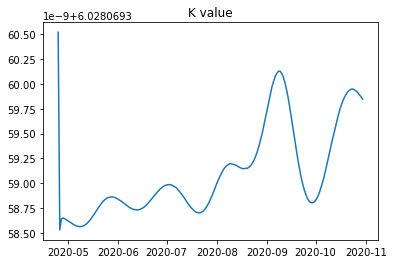

In [22]:
plt.plot(K_vals.index, K_vals)
plt.title('K value')

In [ ]:
n = len(prop_ma7.values)
f_t = np.fft.fft(prop_ma7.values, n)

mag = np.sqrt(f_t * np.conj(f_t))
freq = (1/n)* np.arange(n)
L = np.arange(1, np.floor(n/2), dtype='int64')
plt.plot(freq[L], mag[L])

In [ ]:
prop_ma7.values

In [ ]:
# error computations

In [23]:
# compute squared error for the overlapping time period -------------------------
d = datetime.date(2020, 10, 23)
start = datetime.date(2020, 4, 18)

left = predicted_seiir_prior.index[0]
right = d

seiir_err = case_ma7_all.loc[left:right] - predicted_seiir_prior[left:right]
seiir_sum_sq_err = (seiir_err**2).sum()
seiir_mse = seiir_sum_sq_err / seiir_err.count()

kalman_err = predicted_case.loc[left:right] - case_ma7_all.loc[left:right]
kalman_sum_sq_err = (kalman_err**2).sum()
kalman_mse = kalman_sum_sq_err / kalman_err.count()


print('SSE between seiir forecast and case rate:', seiir_sum_sq_err)
print('MSE between seiir forecast and measured case rate:', seiir_mse)
print()
print('SSE between kalman forecast and case rate:', kalman_sum_sq_err)
print('MSE between kalman forecast and measured case rate:', kalman_mse)

SSE between seiir forecast and case rate: 90051244.56330055
MSE between seiir forecast and measured case rate: 494787.0580401129

SSE between kalman forecast and case rate: 116969.06568203545
MSE between kalman forecast and measured case rate: 642.6871740771179


In [ ]:
calc_mse(predicted_case.loc[left:right], case_ma7_all.loc[left:right])

In [ ]:
output_df = pd.DataFrame()
output_df[the_county] = predicted_case

In [ ]:
output_df.to_csv(r'output/predicted_case_example.csv')

# All plotting code below this

In [ ]:
xlim_left = None
xlim_right = None

leftylim_low = None
leftylim_high = None

rightylim_low = None
rightylim_high = None

xtick_size = 14
xlabel_size = 14

In [25]:
# plot findings -- multiple plots

# Plotting constants and variables ----------------

plt.style.use('seaborn-whitegrid')
matplotlib.rcParams.update({'font.size': 18})
purple = '#33016F'
gold = '#9E7A27'
gray = '#797979'
width = 4
%matplotlib qt

tick_end = predicted_seiir_prior.index[-1]

week_interval = pd.date_range(start=start, end=tick_end, freq='W')
week_interval = [x.to_pydatetime().date() for x in week_interval]



In [ ]:
# multiple plots -----------
fig1, ax11 = plt.subplots(1)
plt.sca(ax11)
plt.plot(case_ma7_all.loc[start:d].index, case_ma7_all.loc[start:d], label='Confirmed Case Count', c=gold,
         linewidth=width)
plt.xticks(week_interval, rotation=30, ha='right', rotation_mode='anchor', fontsize=xtick_size)
plt.ylabel('Number of Cases per Day')
plt.legend(loc='upper left')
plt.ylim(leftylim_low, leftylim_high)
plt.xlim(xlim_left, xlim_right)


fig2, ax21 = plt.subplots(1)
plt.sca(ax21)
plt.plot(case_ma7_all.loc[start:d].index, case_ma7_all.loc[start:d], label='Confirmed Case Count', c=gold,
         linewidth=width)
plt.plot(predicted_seiir_prior.index, predicted_seiir_prior,
         label='IHME 7-day Forecast', c=gray, linewidth=width)
plt.xticks(week_interval, rotation=30, ha='right', rotation_mode='anchor', fontsize=xtick_size)
plt.ylabel('Number of Cases per Day')
plt.legend(loc='upper left')
plt.ylim(leftylim_low, leftylim_high)
plt.xlim(xlim_left, xlim_right)




fig3, ax31 = plt.subplots(1)
plt.sca(ax31)
plt.plot(case_ma7_all.loc[start:d].index, case_ma7_all.loc[start:d], label='Confirmed Case Count', c=gold,
         linewidth=width)
plt.plot(predicted_seiir_prior.index, predicted_seiir_prior,
         label='IHME 7-day Forecast', c=gray, linewidth=width)

ax32 = ax31.twinx()
plt.sca(ax32)
plt.plot(num_stl_ma7.loc[start:d].index, num_stl_ma7.loc[start:d], c='red', label='FB Positive Symptoms, Smell/Taste Loss',
         linewidth=width)
plt.grid(axis='y', linestyle=':')

plt.ylabel('Number of Positive Symptom Response per Day')
plt.legend(loc='upper right')
plt.ylim(rightylim_low, rightylim_high)


plt.sca(ax31)
plt.xticks(week_interval, rotation=30, ha='right', rotation_mode='anchor', fontsize=xtick_size)
plt.ylabel('Number of Cases per Day')

plt.legend(loc='upper left')
plt.ylim(leftylim_low, leftylim_high)
plt.xlim(xlim_left, xlim_right)






In [26]:
fig4, ax41 = plt.subplots(1)
plt.sca(ax41)
plt.plot(case_ma7_all.loc[start:d].index, case_ma7_all.loc[start:d], label='Confirmed Case Count', c=gold,
         linewidth=width)
plt.plot(predicted_seiir_prior.index, predicted_seiir_prior,
         label='IHME 7-day Forecast', c=gray, linewidth=width)
#naieve estimate
naive_start = start + datetime.timedelta(days=7)
naive_d = d + datetime.timedelta(days=7)
plt.plot(case_ma7_all.loc[naive_start:naive_d].index, case_ma7_all.loc[start:d], label='Naive guess', c='orange')

ax42 = ax41.twinx()
plt.sca(ax42)
plt.plot(num_survey_ma7.loc[start:d].index, num_survey_ma7.loc[start:d], c='red', label='FB Positive Symptoms, Smell/Taste Loss',
         linewidth=width)
plt.grid(axis='y', linestyle=':')

plt.ylabel('Number of Positive Household Symptom Response per Day')
plt.legend(loc='upper right')
plt.ylim(rightylim_low, rightylim_high)


plt.sca(ax41)
plt.plot(predicted_case.loc[start:].index, predicted_case.loc[start:], label='Our 7-Day Forecast',
         c=purple, linewidth=width)

plt.xticks(week_interval, rotation=30, ha='right', rotation_mode='anchor', fontsize=xtick_size)
plt.ylabel('Number of Cases per Day')

plt.legend(loc='upper left')
plt.ylim(leftylim_low, leftylim_high)
plt.xlim(xlim_left, xlim_right)

(737517.0, 737732.0)

In [ ]:
case_ma7_all.loc[d]


In [ ]:
plt.grid()

In [ ]:
## special end date

# plot findings -- multiple plots

# Plotting constants and variables ----------------
matplotlib.rcParams.update({'font.size': 18})
plt.style.use('seaborn-whitegrid')
purple = '#33016F'
gold = '#9E7A27'
gray = '#797979'
width = 4
%matplotlib qt

tick_end = predicted_seiir_prior.index[-1]

week_interval = pd.date_range(start=start, end=tick_end, freq='W')
week_interval = [x.to_pydatetime().date() for x in week_interval]


fig1, ax11 = plt.subplots(1)
plt.sca(ax11)
plt.plot(case_ma7_all.loc[start:tick_end].index, case_ma7_all.loc[start:tick_end], label='Confirmed Case Count', c=gold,
         linewidth=width)
plt.xticks(week_interval, rotation=30, ha='right', rotation_mode='anchor', fontsize=xtick_size)
plt.ylabel('Number of Cases per Day')
plt.legend(loc='upper left')
plt.ylim(leftylim_low, leftylim_high)
plt.xlim(xlim_left, xlim_right)


fig2, ax21 = plt.subplots(1)
plt.sca(ax21)
plt.plot(case_ma7_all.loc[start:tick_end].index, case_ma7_all.loc[start:tick_end], label='Confirmed Case Count', c=gold,
         linewidth=width)
plt.plot(predicted_seiir_prior.index, predicted_seiir_prior,
         label='IHME 7-day Forecast', c=gray, linewidth=width)
plt.xticks(week_interval, rotation=30, ha='right', rotation_mode='anchor', fontsize=xtick_size)
plt.ylabel('Number of Cases per Day')
plt.legend(loc='upper left')
plt.ylim(leftylim_low, leftylim_high)
plt.xlim(xlim_left, xlim_right)




fig3, ax31 = plt.subplots(1)
plt.sca(ax31)
plt.plot(case_ma7_all.loc[start:tick_end].index, case_ma7_all.loc[start:tick_end], label='Confirmed Case Count', c=gold,
         linewidth=width)
plt.plot(predicted_seiir_prior.index, predicted_seiir_prior,
         label='IHME 7-day Forecast', c=gray, linewidth=width)

ax32 = ax31.twinx()
plt.sca(ax32)
plt.plot(num_stl_ma7.loc[start:tick_end].index, num_stl_ma7.loc[start:tick_end], c='red', label='FB Positive Symptoms, Smell/Taste Loss',
         linewidth=width)
plt.grid(axis='y', linestyle=':')

plt.ylabel('Number of Positive Symptom Response per Day')
plt.legend(loc='upper right')
plt.ylim(rightylim_low, rightylim_high)


plt.sca(ax31)
plt.xticks(week_interval, rotation=30, ha='right', rotation_mode='anchor', fontsize=xtick_size)
plt.ylabel('Number of Cases per Day')

plt.legend(loc='upper left')
plt.ylim(leftylim_low, leftylim_high)
plt.xlim(xlim_left, xlim_right)



fig4, ax41 = plt.subplots(1)
plt.sca(ax41)
plt.plot(case_ma7_all.loc[start:tick_end].index, case_ma7_all.loc[start:tick_end], label='Confirmed Case Count', c=gold,
         linewidth=width)
plt.plot(predicted_seiir_prior.index, predicted_seiir_prior,
         label='IHME 7-day Forecast', c=gray, linewidth=width)

ax42 = ax41.twinx()
plt.sca(ax42)
plt.plot(num_stl_ma7.loc[start:tick_end].index, num_stl_ma7.loc[start:tick_end], c='red', label='FB Positive Symptoms, Smell/Taste Loss',
         linewidth=width)
plt.grid(axis='y', linestyle=':')

plt.ylabel('Number of Positive Symptom Response per Day')
plt.legend(loc='upper right')
plt.ylim(rightylim_low, rightylim_high)


plt.sca(ax41)
plt.plot(predicted_case.loc[start:].index, predicted_case.loc[start:], label='Our 7-Day Forecast',
         c=purple, linewidth=width)

plt.xticks(week_interval, rotation=30, ha='right', rotation_mode='anchor', fontsize=xtick_size)
plt.ylabel('Number of Cases per Day')

plt.legend(loc='upper left')
plt.ylim(leftylim_low, leftylim_high)
plt.xlim(xlim_left, xlim_right)


In [ ]:
# NYC plot settings

xlim_left = datetime.date(2020, 4, 2)
xlim_right = datetime.date(2020, 11, 3)

leftylim_low = -700
leftylim_high = 12000

rightylim_low = -5
rightylim_high = 85

xtick_size = 14
xlabel_size = 14

In [ ]:
# Nassau plot settings
xlim_left = datetime.date(2020, 4, 2)
xlim_right = datetime.date(2020, 11, 3)

leftylim_low = -40
leftylim_high = 1650

rightylim_low = -.3
rightylim_high = 12

xtick_size = 14
xlabel_size = 14

In [24]:
# Westchester plot settings
xlim_left = datetime.date(2020, 4, 2)
xlim_right = datetime.date(2020, 11, 3)

leftylim_low = -28
leftylim_high = 1000

rightylim_low = -.2
rightylim_high = 7

xtick_size = 14
xlabel_size = 14

In [ ]:
# Albany plot settings
xlim_left = datetime.date(2020, 4, 2)
xlim_right = datetime.date(2020, 11, 3)

leftylim_low = -3
leftylim_high = 75

rightylim_low = -.125
rightylim_high = 3.1

xtick_size = 14
xlabel_size = 14

In [ ]:
# Erie plot settings
xlim_left = datetime.date(2020, 4, 2)
xlim_right = datetime.date(2020, 10, 13)

leftylim_low = -10
leftylim_high = 250

rightylim_low = -.5
rightylim_high = 12.5

xtick_size = 14
xlabel_size = 14